# Evaluation of the regressor

Metric                   Ground Truth        Prediction          
-----------------------------------------------------------------
Left Angle               120.76              120.34953338583954  
Right Angle              121.00              120.75940217242689  
Volume                   66314.00            66211.75            


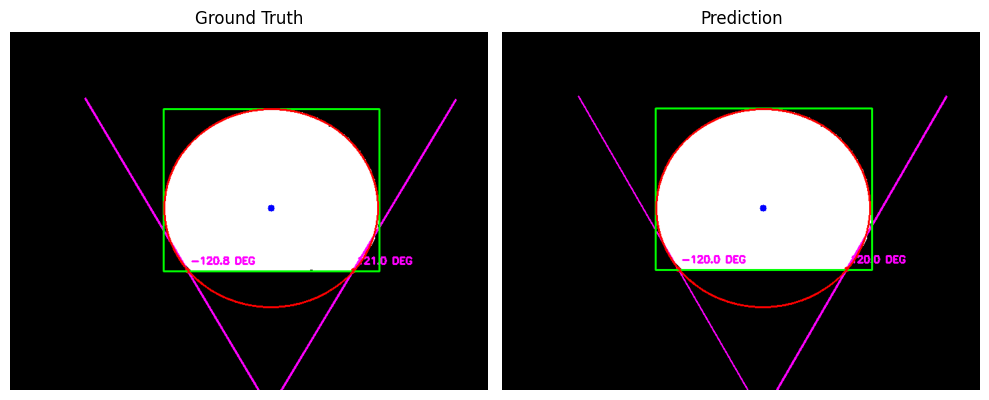

Metric                   Ground Truth        Prediction          
-----------------------------------------------------------------
Left Angle               120.20              119.52065799995736  
Right Angle              120.62              119.98113195042377  
Volume                   63344.00            63462.54            


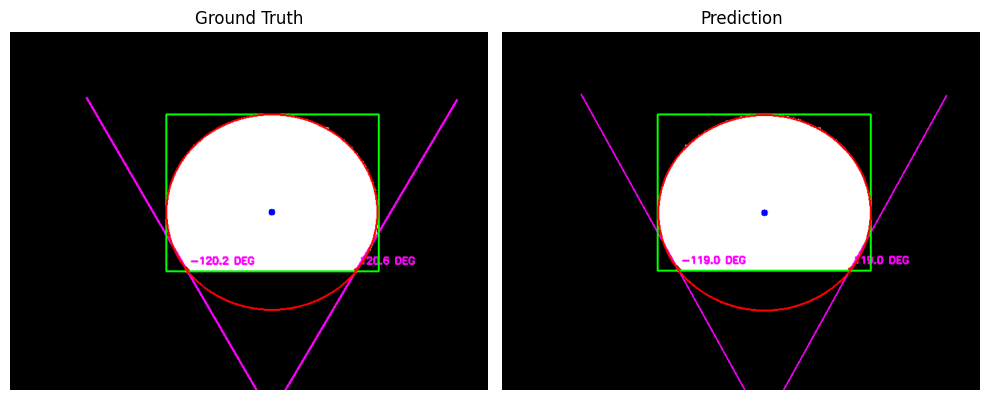

Metric                   Ground Truth        Prediction          
-----------------------------------------------------------------
Left Angle               118.98              119.43612098501431  
Right Angle              118.96              119.91250748479115  
Volume                   63315.00            63385.76            


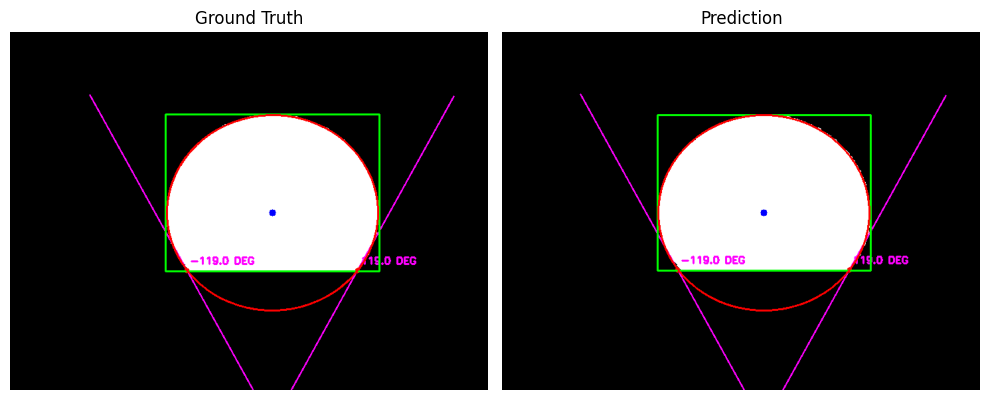

Metric                   Ground Truth        Prediction          
-----------------------------------------------------------------
Left Angle               119.92              120.06830774616071  
Right Angle              120.90              120.5050269294054   
Volume                   69153.00            69582.65            


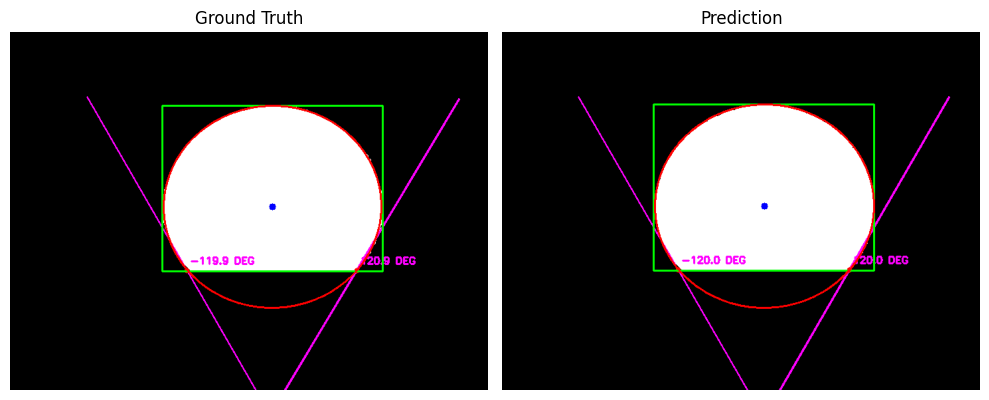

In [12]:
import cv2
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from utils import mark_point_on_mask, mark_bounding_box_on_mask, mark_ellipse_on_mask, mark_tangent_and_angle_on_mask, mark_tangent_and_angle_given_angle
import torch
from cnn_model import DropletCNNRegressor
from joblib import load

MASK_DIR = "../3. Segmentation and Detection Models/droplet_masks"
REGRESSION_INFO_PATH = "../5. Robust Estimation and Evaluation Methods/analysis/droplet_analysis.csv"

# Load the regression information CSV
regression_info = pd.read_csv(REGRESSION_INFO_PATH)

# Select 4 random rows from the dataframe
random_rows = regression_info.sample(n=4, random_state=42)

# Load the model
model_path = "cnn_regressor_best.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DropletCNNRegressor().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Iterate through the selected rows
for _, row in random_rows.iterrows():
    frame_id = int(row['Frame'])
    mask_path = os.path.join(MASK_DIR, f"frame_{frame_id:03d}_mask.png")
    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
    if mask is None:
        print(f"Failed to load: {mask_path}")
        continue

    xc, yc = int(row['Ellipse_XC']), int(row['Ellipse_YC'])

    # Ground truth marked mask
    # marked_mask = mark_tangent_and_angle_on_mask(mask, frame_id, xc, yc, row['Ellipse_A'], row['Ellipse_B'], row['BBox_Y'], row['BBox_H'])
    marked_mask = mark_tangent_and_angle_given_angle(mask, xc, yc, row['Ellipse_A'], row['Ellipse_B'], row['Ellipse_Theta'], [row['Left_Angle'], row['Right_Angle']], row['BBox_Y'], row['BBox_H'])
    marked_mask = mark_point_on_mask(marked_mask, xc, yc)
    marked_mask = mark_bounding_box_on_mask(marked_mask, row['BBox_X'], row['BBox_Y'], row['BBox_W'], row['BBox_H'])
    marked_mask = mark_ellipse_on_mask(marked_mask, xc, yc, row['Ellipse_A'], row['Ellipse_B'], row['Ellipse_Theta'])

    # Preprocess the mask for inference
    input_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    input_mask = cv2.resize(input_mask, (240, 180))  # <- MATCH TRAINING SIZE
    input_mask = input_mask / 255.0
    input_mask = torch.tensor(input_mask, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    # Infer the values
    with torch.no_grad():
        predictions = model(input_mask)

    scaler = load("scaler.joblib")
    pred_np = predictions.cpu().numpy().flatten()         # Shape: (12,)
    pred = scaler.inverse_transform([pred_np])[0]         # Shape: (12,)
    
    # Predicted marked mask
    pred_left_angle, pred_right_angle = int(pred[0]), int(pred[1])
    pred_xc, pred_yc = int(pred[3]), int(pred[4])
    pred_a, pred_b, pred_theta = pred[5], pred[6], pred[7]
    pred_bbox_x, pred_bbox_y, pred_bbox_w, pred_bbox_h = map(int, pred[8:12])


    # Display ground truth and predicted angles in a formatted table
    print(f"{'Metric':<25}{'Ground Truth':<20}{'Prediction':<20}")
    print("-" * 65)
    print(f"{'Left Angle':<25}{row['Left_Angle']:<20.2f}{pred[0]:<20}")
    print(f"{'Right Angle':<25}{row['Right_Angle']:<20.2f}{pred[1]:<20}")
    print(f"{'Volume':<25}{row['Volume']:<20.2f}{pred[2]:<20.2f}")

    marked_pred = mark_tangent_and_angle_given_angle(mask, pred_xc, pred_yc, pred_a, pred_b, pred_theta, [pred_left_angle, pred_right_angle], pred_bbox_y, pred_bbox_h)
    marked_pred = mark_point_on_mask(marked_pred, pred_xc, pred_yc)
    marked_pred = mark_bounding_box_on_mask(marked_pred, pred_bbox_x, pred_bbox_y, pred_bbox_w, pred_bbox_h)
    marked_pred = mark_ellipse_on_mask(marked_pred, pred_xc, pred_yc, pred_a, pred_b, pred_theta)

    # Convert to RGB for matplotlib
    marked_gt_rgb = cv2.cvtColor(marked_mask, cv2.COLOR_BGR2RGB)
    marked_pred_rgb = cv2.cvtColor(marked_pred, cv2.COLOR_BGR2RGB)

    # Display side-by-side
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(marked_gt_rgb)
    axs[0].set_title("Ground Truth")
    axs[0].axis("off")

    axs[1].imshow(marked_pred_rgb)
    axs[1].set_title("Prediction")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()
